In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import relativedelta

In [2]:
def plotling(df,col):
    import plotly.graph_objects as go
    x = go.Scatter(x=df.index, y=df[col])
    fig = go.Figure(x)
    fig.show()

Estimating PET

In order to determine potential evaporation, Penman formula was employed for the case of Leiden. The four required measured parameters were: mean wind speed (m/s),  mean temperature ($^{o}C$), incoming radiation ($J m^{-2}$), and relative humidity (\%). Measurements were derived by KNMI weather stations

\begin{equation} 
E_{p} =\frac{\frac{s (R_{n}-G) }{\rho \lambda}+\frac{c_{p} \rho_{a}}{\rho \lambda} \frac{\left(e_{s}-e_{a}\right)}{r_{a}}}{s+\gamma} \label{eq:Penman} \tag{1}
\end{equation}
where:

$E_p$: Penman potential evaporation (m/s) <br/>
$R_n $: net radiation on the earth's surface ($J s^{-1} m^{-2}$)  <br/>
G: ground heat flux ($J s^{-1} m^{-2}$)<br/>
$\lambda$: latent heat of vaporization (2.45 MJ/kg) <br/>
s: slope of saturation vapor pressure-temperature curve ($kPa/^{o}C$) <br/>
$c_{p}$: specific heat of air ($1004 \frac{J}{kg K}$) <br/>
$\rho_\alpha$: density of air ($1.205 \frac{kg}{m^{3}}$) <br/>
$\rho$: density of water (1000 $\frac{kg}{m^{3}}$) <br/>
$e_a$: actual vapor pressure in the air at 2m height (kPa) <br/>
$e_s$: saturation vapor pressure in the air at 2m height (kPa) <br/>
$\gamma$: psychrometric constant (0.066 $\frac{kPa}{^{o}C}$) <br/>
$r_a$: aerodynamic resistance (s/m) <br/>
    

Before applying Formula $\eqref{eq:Penman}$, the following calculations preceded. Aerodynamic resistance was estimated based on Formula $\eqref{eq:f_u}$ and $\eqref{eq:r_a}$, where f(u) is an intermediate parameter (${J}/{m^{2}s Pa}$), and u is wind velocity (m/s). The constants $\rho_\alpha$, $c_{p}$, and $\gamma$ were defined above. In Formula $\eqref{eq:r_a}$, the unit of $\gamma$ was Pa and not KPa.

\begin{equation} 
    f(u) = 7.4 \times 10^{-2} (0.5+0.54u) {\label{eq:f_u}} \tag{2}
\end{equation}

\begin{equation} {\label{eq:r_a}}
    r_a = \frac{\rho_\alpha c_{p}}{\gamma f(u)} \tag{3}
\end{equation} 


Subsequently, saturation vapor pressure ($e_{s}$) was estimated based on Formula $\eqref{eq:e_s}$, where T is temperature ($^{o}C$). Combining it with relative humidity (RH in \%), the actual vapor pressure was estimated. Formula $\eqref{eq:e_a}$. Then, the slope of \`saturation vapor pressure' - \`temperature' curve was calculated which showed how quickly the dew point (where condensation occurs) could be reached considering the current air temperature. The temperature in Formula (\ref{eq:slope}) was in $^{o}$C.

\begin{equation} 
e_{s}(T)=0.61 \exp \left(\frac{19,9 T}{273+T}\right) \label{eq:e_s} \tag{4}
\end{equation}

\begin{equation} 
e_{a}(T) = \frac{RH}{e_s} \label{eq:e_a} \tag{5}
\end{equation} 

\begin{equation} 
s=\frac{5430 e_{s}}{(273+T)^{2}}  \label{eq:slope} \tag{6}
\end{equation}

One of the main parameters which determine evaporation is net radiation which can be calculated by Formula (\ref{eq:net_radiation}) where, $R_{s, in}$ is shortwave incoming radiation, $R_{s, out}$ is shortwave reflected radiation from the Earth's surface to the atmosphere, $R_{l, in}$ is the longwave incoming radiation which is scattered from the atmosphere (mainly clouds, and greenhouse gases) back to the Earth, and $R_{l, out}$ is the longwave radiation which is not scattered back but is released into the atmosphere. Albedo (r) determines the ratio of $R_{s, out}$ to  $R_{s, in}$ and depends on brightness of the land use; it is dimensionless and varies from 0 (black surface) to 1 (white surface). However, Formula (\ref{eq:net_radiation}) was not applied since net longwave radiation ($R_{l,n}$) was not estimated. For the calculation of $R_{l,n}$, the percentage of sunshine per hour is required but there was lack of information regarding it. Consequently, an assumption was made that $R_{n} = 0.65R_{s, in}$

\begin{equation} 
R_{n}=\left(R_{s, i n}-R_{s, o u t}\right)-\left(R_{l, o u t}-R_{l, i n}\right)=R_{s, i n}-r R_{s, i n}-R_{l, n}=(1-r) R_{s, i n}-R_{l, n} \label{eq:net_radiation} \tag{7}
\end{equation}

Another assumption was applied too. Considering that cities are built by materials which absorb more radiation compared to rural environment, it was assumed that $G= 0.1 R_n$.

In [29]:
def NLD_station_rain_PET(df_path):
    """
    This function returns the precipitation and PET time series given that measurements
    of weather stations in NLD are provided
    Input: file from KNMI for one weather station
    Output: df with 2 columns: (1) precipitation, and (2) Penman  Evaporation
    """
    weather_data=pd.read_csv(df_path, skiprows=31, skipinitialspace=True, low_memory=False)
    cols_delete = set(weather_data.columns) - set(['# STN', 'YYYYMMDD', 'HH', 'FH', 'Q', 'RH', 'U', 'T'])
    weather_data.drop(cols_delete, axis=1, inplace=True)
    # The following two commands could be used in the case the columns 'YYYYMMDD' and 'HH' were float
    # weather_data['YYYYMMDD'] = pd.to_numeric(weather_data['YYYYMMDD'], downcast='integer')
    # weather_data['HH'] = pd.to_numeric(weather_data['HH'], downcast='integer')
    weather_data['HH'] = weather_data['HH'] -1
    weather_data['HH'] = weather_data['HH'].astype(str)
    weather_data['HH'] = weather_data['HH'].str.zfill(2)
    weather_data['combined_date'] = weather_data['YYYYMMDD'].map(str) + ':' + weather_data['HH'].map(str)
    weather_data['combined_date'] = pd.to_datetime(weather_data['combined_date'], format='%Y%m%d:%H')
    weather_data.set_index('combined_date', inplace=True)

    # When the rainfall is <0.05 mm, -1 was assigned. In order to avod problems in the further steps, we replaced this values to 0. 
    weather_data.RH.replace(-1,0, inplace=True)
    weather_data['RH'] = weather_data['RH']/10
    weather_data.drop(['# STN', 'YYYYMMDD', 'HH'], axis=1, inplace=True)
    
    # Estimating net radiation
    weather_data.loc[:,'FH']=weather_data.loc[:,'FH']/10 # conversion - it is provided in (in 0.1 m/s)
    weather_data.loc[:,'T']=weather_data.loc[:,'T']/10 # conversion - it is provided in 0.1 degrees Celsius 
    # For RH (rainfall, I have already divided by 10)
    weather_data.loc[:,'Q']=weather_data.loc[:,'Q']*10000/3600 # unit conversion J/(h cm^2) -> J/(s m^2)
    weather_data.rename(columns={'T':'Temp'}, inplace=True)
    weather_data['fu']=0.074*(0.5+0.54*weather_data.FH)
    weather_data['ra']=1.205*1004/(0.066*1000*weather_data.fu)
    weather_data['es']=0.61*np.exp(19.9*weather_data.Temp/(273+weather_data.Temp))
    weather_data['ea']=weather_data.U/100*weather_data.es
    weather_data['delta']=5430*weather_data.es/(273+weather_data.Temp)**2
    weather_data['Rn'] =  0.65 * weather_data.Q
    weather_data['G']=0.1*weather_data.Rn
    weather_data['rholE_nom']=weather_data.delta*(weather_data.Rn-weather_data.G) +\
    1.205*1004/weather_data.ra*(weather_data.es - weather_data.ea)
    weather_data['rholE_denom']=weather_data.delta + 0.066  #*(1+ weather_data.ra)
    weather_data['rholE'] = weather_data['rholE_nom'] / weather_data['rholE_denom']
    weather_data['E_pot_OW'] = weather_data.rholE / (2.45e6*1000) * 3600 * 1000  # result: evaporation in mm/h
    
    return weather_data

path = r'Weather_stations_datasets\uurgeg_210_2011-2020.txt'
NLD_station_rain_PET(path).head()

,FH,Temp,Q,RH,U,fu,ra,es,ea,delta,Rn,G,rholE_nom,rholE_denom,rholE,E_pot_OW
combined_date,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,4.0,4.9,0.0,0.0,99,0.19684,93.124396,0.866395,0.857731,0.060917,0.0,0.0,0.112557,0.126917,0.886856,0.001303
2011-01-01 01:00:00,6.0,5.1,0.0,0.0,95,0.27676,66.232859,0.878661,0.834728,0.061691,0.0,0.0,0.802488,0.127691,6.284630,0.009235
2011-01-01 02:00:00,6.0,5.1,0.0,0.0,92,0.27676,66.232859,0.878661,0.808368,0.061691,0.0,0.0,1.283982,0.127691,10.055407,0.014775
2011-01-01 03:00:00,5.0,4.9,0.0,0.0,95,0.23680,77.409654,0.866395,0.823075,0.060917,0.0,0.0,0.677035,0.126917,5.334474,0.007838
2011-01-01 04:00:00,5.0,5.3,0.0,0.0,91,0.23680,77.409654,0.891084,0.810886,0.062473,0.0,0.0,1.253391,0.128473,9.756072,0.014335


<AxesSubplot:xlabel='combined_date'>

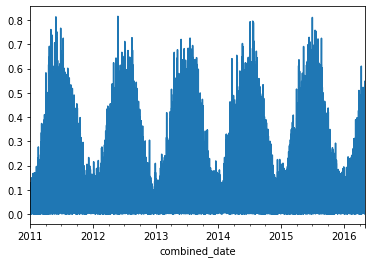

In [35]:
NLD_station_rain_PET(path).E_pot_OW.plot()

# Intro

In [5]:
weather_data = NLD_station_rain_PET(path)

cols_delete = set(NLD_station_rain_PET(path).columns) - set(['# STN', 'YYYYMMDD', 'HH', 'FH', 'Q', 'RH', 'U', 'T'])
weather_data.drop(cols_delete, axis=1, inplace=True)
weather_data.head()

,# STN,YYYYMMDD,HH,FH,T,Q,RH,U
0,210,20110101,1,40,49,0,-1,99
1,210,20110101,2,60,51,0,-1,95
2,210,20110101,3,60,51,0,0,92
3,210,20110101,4,50,49,0,0,95
4,210,20110101,5,50,53,0,0,91


In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46776 entries, 0 to 46775
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   # STN     46776 non-null  int64
 1   YYYYMMDD  46776 non-null  int64
 2   HH        46776 non-null  int64
 3   FH        46776 non-null  int64
 4   T         46776 non-null  int64
 5   Q         46776 non-null  int64
 6   RH        46776 non-null  int64
 7   U         46776 non-null  int64
dtypes: int64(8)
memory usage: 2.9 MB


In [7]:
weather_data.dtypes

# STN       int64
YYYYMMDD    int64
HH          int64
FH          int64
T           int64
Q           int64
RH          int64
U           int64
dtype: object

In [8]:
# weather_data.head(25)

In [9]:
# The following two commands could be used in the case the columns 'YYYYMMDD' and 'HH' were float
# weather_data['YYYYMMDD'] = pd.to_numeric(weather_data['YYYYMMDD'], downcast='integer')
# weather_data['HH'] = pd.to_numeric(weather_data['HH'], downcast='integer')
weather_data['HH'] = weather_data['HH'] -1

In [10]:
weather_data.tail()

,# STN,YYYYMMDD,HH,FH,T,Q,RH,U
46771,210,20160502,19,40,122,0,0,84
46772,210,20160502,20,50,122,0,0,83
46773,210,20160502,21,60,124,0,0,80
46774,210,20160502,22,60,113,0,20,92
46775,210,20160502,23,50,126,22,1,86


In [11]:
weather_data['HH'] = weather_data['HH'].astype(str)
weather_data['HH'] = weather_data['HH'].str.zfill(2)
weather_data['combined_date'] = weather_data['YYYYMMDD'].map(str) + ':' + weather_data['HH'].map(str)
weather_data['combined_date'] = pd.to_datetime(weather_data['combined_date'], format='%Y%m%d:%H')
weather_data.set_index('combined_date', inplace=True)

# When the rainfall is <0.05 mm, -1 was assigned. In order to avod problems in the further steps, we replaced this values to 0. 
weather_data.RH.replace(-1,0, inplace=True)
weather_data['RH'] = weather_data['RH']/10

In [13]:
weather_data.shape

(46776, 8)

Stations '248', '324', '340', and '343' were removed since there was lack of some measurements necesssary for estimation of Penman Evaporation 

<AxesSubplot:xlabel='combined_date'>

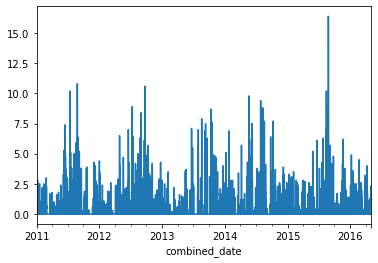

In [14]:
weather_data.RH.plot()

In [15]:
weather_data.drop(['# STN', 'YYYYMMDD', 'HH'], axis=1, inplace=True)

In [16]:
weather_data

,FH,T,Q,RH,U
combined_date,,,,,
2011-01-01 00:00:00,40,49,0,0.0,99
2011-01-01 01:00:00,60,51,0,0.0,95
2011-01-01 02:00:00,60,51,0,0.0,92
2011-01-01 03:00:00,50,49,0,0.0,95
2011-01-01 04:00:00,50,53,0,0.0,91
...,...,...,...,...,...
2016-05-02 19:00:00,40,122,0,0.0,84
2016-05-02 20:00:00,50,122,0,0.0,83
2016-05-02 21:00:00,60,124,0,0.0,80


In [17]:
pd.options.mode.chained_assignment = None

In [18]:
weather_data

,FH,T,Q,RH,U
combined_date,,,,,
2011-01-01 00:00:00,40,49,0,0.0,99
2011-01-01 01:00:00,60,51,0,0.0,95
2011-01-01 02:00:00,60,51,0,0.0,92
2011-01-01 03:00:00,50,49,0,0.0,95
2011-01-01 04:00:00,50,53,0,0.0,91
...,...,...,...,...,...
2016-05-02 19:00:00,40,122,0,0.0,84
2016-05-02 20:00:00,50,122,0,0.0,83
2016-05-02 21:00:00,60,124,0,0.0,80


### Estimating Net Radiation

In [19]:
weather_data.loc[:,'FH']=weather_data.loc[:,'FH']/10 # conversion - it is provided in (in 0.1 m/s)
weather_data.loc[:,'T']=weather_data.loc[:,'T']/10 # conversion - it is provided in 0.1 degrees Celsius 
# For RH (rainfall, I have already divided by 10)
weather_data.loc[:,'Q']=weather_data.loc[:,'Q']*10000/3600 # unit conversion J/(h cm^2) -> J/(s m^2)
weather_data.rename(columns={'T':'Temp'}, inplace=True)
weather_data['fu']=0.074*(0.5+0.54*weather_data.FH)
weather_data['ra']=1.205*1004/(0.066*1000*weather_data.fu)
weather_data['es']=0.61*np.exp(19.9*weather_data.Temp/(273+weather_data.Temp))
weather_data['ea']=weather_data.U/100*weather_data.es
weather_data['delta']=5430*weather_data.es/(273+weather_data.Temp)**2

Add an image for Penmann equation

SOS - add hyperlinks to the formulas

# Energy Balance

<img src="Images/Scheme-of-the-Earths-energy-budget.png" width='600'>

Text(0.5, 1.0, 'Penman Evaporation')

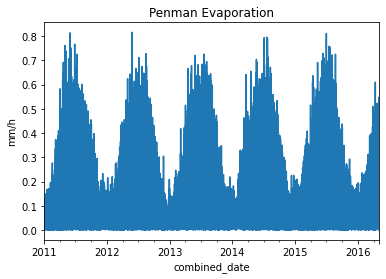

In [27]:
weather_data['Rn'] =  0.65 * weather_data.Q
weather_data['G']=0.1*weather_data.Rn
weather_data['rholE_nom']=weather_data.delta*(weather_data.Rn-weather_data.G) +\
1.205*1004/weather_data.ra*(weather_data.es - weather_data.ea)
weather_data['rholE_denom']=weather_data.delta + 0.066  #*(1+ weather_data.ra)
weather_data['rholE'] = weather_data['rholE_nom'] / weather_data['rholE_denom']
weather_data['E_pot_OW'] = weather_data.rholE / (2.45e6*1000) * 3600 * 1000  # result: evaporation in mm/h
weather_data.E_pot_OW.plot()
plt.ylabel('mm/h')
plt.title('Penman Evaporation')

In [23]:
# a=0.35 #Assumption for the value of albedo

In [24]:
weather_data.head()

,FH,Temp,Q,RH,U,fu,ra,es,ea,delta,Rn,G,rholE_nom,rholE_denom,rholE,E_pot_OW
combined_date,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,4.0,4.9,0.0,0.0,99,0.19684,93.124396,0.866395,0.857731,0.060917,0.0,0.0,0.112557,0.126917,0.886856,0.001303
2011-01-01 01:00:00,6.0,5.1,0.0,0.0,95,0.27676,66.232859,0.878661,0.834728,0.061691,0.0,0.0,0.802488,0.127691,6.284630,0.009235
2011-01-01 02:00:00,6.0,5.1,0.0,0.0,92,0.27676,66.232859,0.878661,0.808368,0.061691,0.0,0.0,1.283982,0.127691,10.055407,0.014775
2011-01-01 03:00:00,5.0,4.9,0.0,0.0,95,0.23680,77.409654,0.866395,0.823075,0.060917,0.0,0.0,0.677035,0.126917,5.334474,0.007838
2011-01-01 04:00:00,5.0,5.3,0.0,0.0,91,0.23680,77.409654,0.891084,0.810886,0.062473,0.0,0.0,1.253391,0.128473,9.756072,0.014335


In [ ]:
weather_final_V2.Q.plot()

In [ ]:
weather_final_V2["Q"][-500:].plot()
plt.legend()

In [ ]:
def plotling(df,col):
    import plotly.graph_objects as go
    x = go.Scatter(x=df.index, y=df[col])
    fig = go.Figure(x)
    fig.show()

In [ ]:
# plotling(weather_final_V2, 'Q')

In [ ]:
weather_final_V2["Q"][-500:].plot()
weather_final_V2['Rn'][-500:].plot()
plt.legend()

In [ ]:
weather_final_V2.RH.plot()

In [ ]:
weather_final_V2.RH.min()

In [ ]:
# I changed this assigment: weather_final.loc[weather_final.Rn<=0,'Rn']=0.05    to 0
 
#weather_final_V2.loc[weather_final_V2.Rn<=0,'Rn'] = 0
weather_final_V2.Rn[:].plot()

In [ ]:
#weather_final_V2.head()

### Estimation of Penman Evaporation

In [ ]:
# Create a table / df for each station via a loop

In [ ]:
weather_final_V2.index.rename('date', inplace=True)
weather_final_V2.to_csv('PET_input_210_hourly_1988_2015.csv', columns=['P_atm','Ref.grass','E_pot_OW'])

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

precip = weather_final_V2.P_atm.plot(label='precipitation')

weather_final_V2.E_pot_OW.plot(secondary_y=True, label='Potential Evaporation')
weather_final_V2['Ref.grass'].plot(secondary_y=True, label='grass Evaporation')

plt.gca().invert_yaxis()
fig.legend(bbox_to_anchor=(0.75, 0.5), bbox_transform=ax.transAxes)

plt.ylabel('Evporation (mm\h)')
plt.text('2018-03-05',0.7,'Precipitation (mm\h)', rotation=90)

plt.savefig('Precip_PET_210_station.png', bbox_to_inches='tight')

### Comparison with Shiyang results in China (order of magnitude)

In [ ]:
# shiyang=pd.read_csv(r'C:\Users\ilias\OneDrive\Desktop\TU_Delft\Graduation_Thesis\Drought_Paper\Urban_Water_Balance_Model\UWBM for Ilias\input\ep_ts.csv', parse_dates=['date'], index_col=['date'])
# shiyang.head()

In [ ]:
# shiyang.P_atm.plot()

In [ ]:
# shiyang['E_pot_OW'].plot()

In [ ]:
# import plotly.graph_objects as go

# e_grass=go.Scatter(x=shiyang.index, y=shiyang['Ref.grass'])
# data=[e_grass]
# fig=go.Figure(data)
# fig.show()